<a href="https://colab.research.google.com/github/forumb94/energypricecode/blob/main/maincode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install plotly

# tensorflow-addons version depends on the tensorflow and python version of the system,
# you can find the compatibility in this link

# https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
#!pip install tensorflow-addons
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
#!pip install --upgrade tensorflow-addons
#!pip install tensorflow-addons==0.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import io

import numpy as np
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
#import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [3]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('final_merged_data_V1.csv')

Saving final_merged_data_V1.csv to final_merged_data_V1.csv


In [4]:
# Read the dataset
df = pd.read_csv(io.BytesIO(uploaded['final_merged_data_V1.csv']))

In [5]:
# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')

# Fill missing values for numeric columns using forward fill, then backward fill as backup
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].ffill().bfill()

# Drop unnecessary columns
#df.drop(columns=['Local Date', 'Hour Number'], inplace=True, errors='ignore')

# Display dataset info
print(df.info())

# Display first few rows
print(df.head())

# Generate summary statistics
summary_stats = df.describe().T
missing_values = df.isnull().sum()
unique_counts = df.nunique()

# Display key statistics
print("\nSummary Statistics:")
print(summary_stats)

print("\nMissing Values Per Column:")
print(missing_values[missing_values > 0])

print("\nUnique Value Counts for Categorical Columns:")
print(unique_counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35081 entries, 0 to 35080
Data columns (total 58 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Local Date                                            35081 non-null  object        
 1   Hour Number                                           35081 non-null  int64         
 2   Time                                                  0 non-null      datetime64[ns]
 3   Total Generation (MW)                                 35081 non-null  float64       
 4   Dual Fuel Generation (MW)                             35081 non-null  float64       
 5   Hydro Generation (MW)                                 35081 non-null  float64       
 6   Natural Gas Generation (MW)                           35081 non-null  float64       
 7   Nuclear Generation (MW)                               35081 non-null  float6

In [6]:
print(df.columns)

Index(['Local Date', 'Hour Number', 'Time', 'Total Generation (MW)',
       'Dual Fuel Generation (MW)', 'Hydro Generation (MW)',
       'Natural Gas Generation (MW)', 'Nuclear Generation (MW)',
       'Other Fossil Fuels Generation (MW)',
       'Other Renewables Generation (MW)', 'Wind Generation (MW)',
       'DAMP A - West', 'DAMP B - Genessee', 'DAMP C - Central',
       'DAMP D - North', 'DAMP E - Mohawk Valley', 'DAMP F - Capital',
       'DAMP G - Hudson Valley', 'DAMP H - Millwood', 'DAMP I - Dunwoodie',
       'DAMP J - New York City', 'DAMP K - Long Island',
       'F - Capital Actual Load (MW)', 'C - Central Actual Load (MW)',
       'I - Dunwoodie Actual Load (MW)', 'B - Genessee Actual Load (MW)',
       'G - Hudson Valley Actual Load (MW)',
       'K - Long Island Actual Load (MW)',
       'E - Mohawk Valley Actual Load (MW)', 'H - Millwood Actual Load (MW)',
       'J - New York City Actual Load (MW)', 'D - North Actual Load (MW)',
       'A - West Actual Load (MW)', 'N

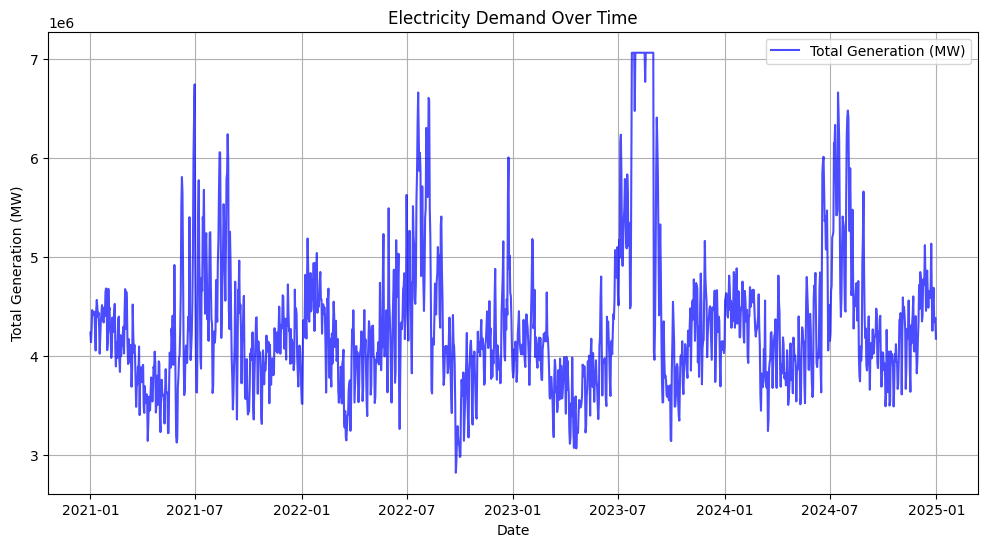

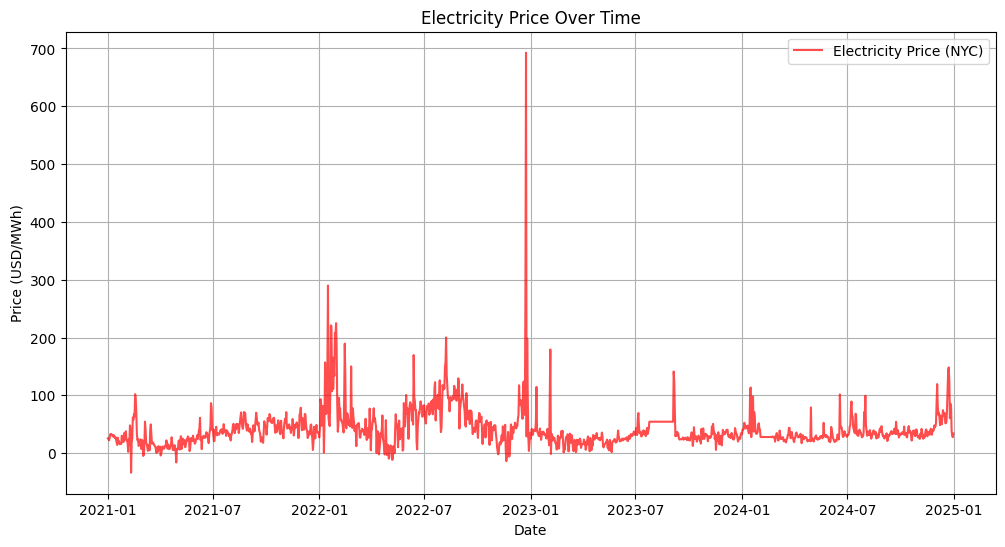

In [7]:
# Convert date column to datetime format for time-series analysis
df['Local Date'] = pd.to_datetime(df['Local Date'])

# Aggregate data by day for visualization
daily_demand = df.groupby('Local Date')['Total Generation (MW)'].sum()
daily_price = df.groupby('Local Date')['Real Time J - New York City'].mean()  # Using NYC as a representative price

# Plot electricity demand over time
plt.figure(figsize=(12, 6))
plt.plot(daily_demand, label='Total Generation (MW)', color='blue', alpha=0.7)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Generation (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Plot electricity price over time
plt.figure(figsize=(12, 6))
plt.plot(daily_price, label='Electricity Price (NYC)', color='red', alpha=0.7)
plt.title('Electricity Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD/MWh)')
plt.legend()
plt.grid(True)
plt.show()


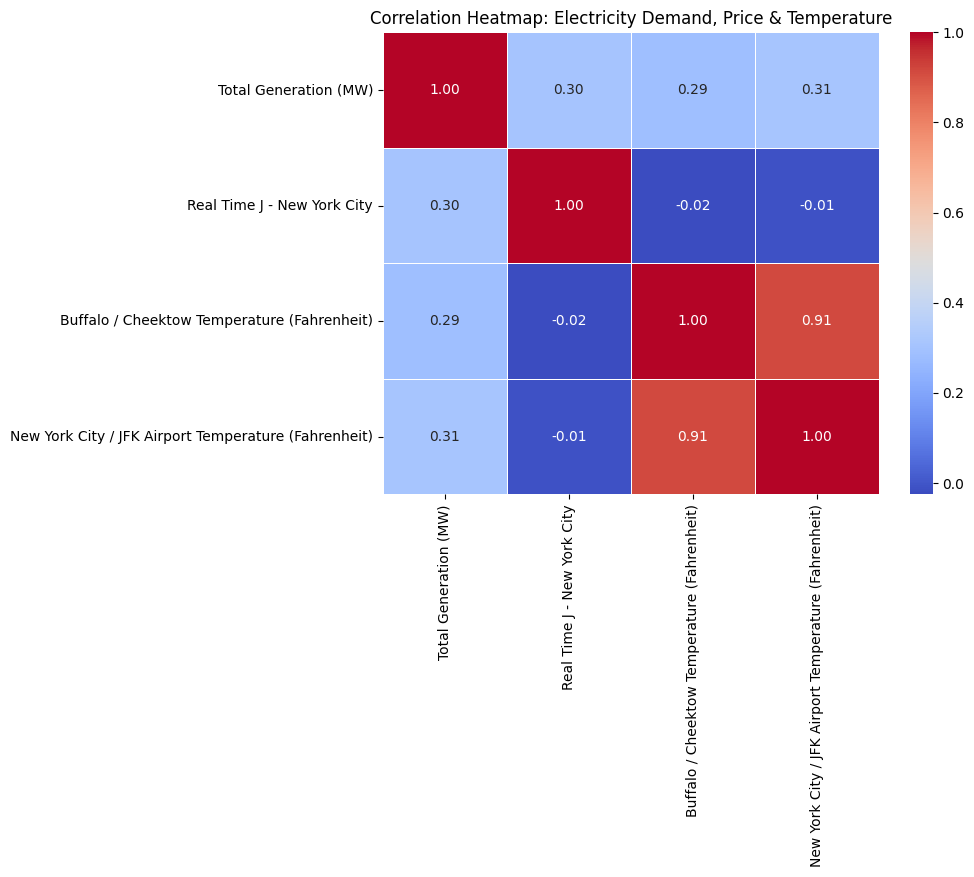

In [8]:
# Compute correlation matrix for relevant numerical variables
relevant_columns = ['Total Generation (MW)', 'Real Time J - New York City',
                    'Buffalo / Cheektow Temperature (Fahrenheit)',
                    'New York City / JFK Airport Temperature (Fahrenheit)']
correlation_matrix = df[relevant_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Electricity Demand, Price & Temperature")
plt.show()


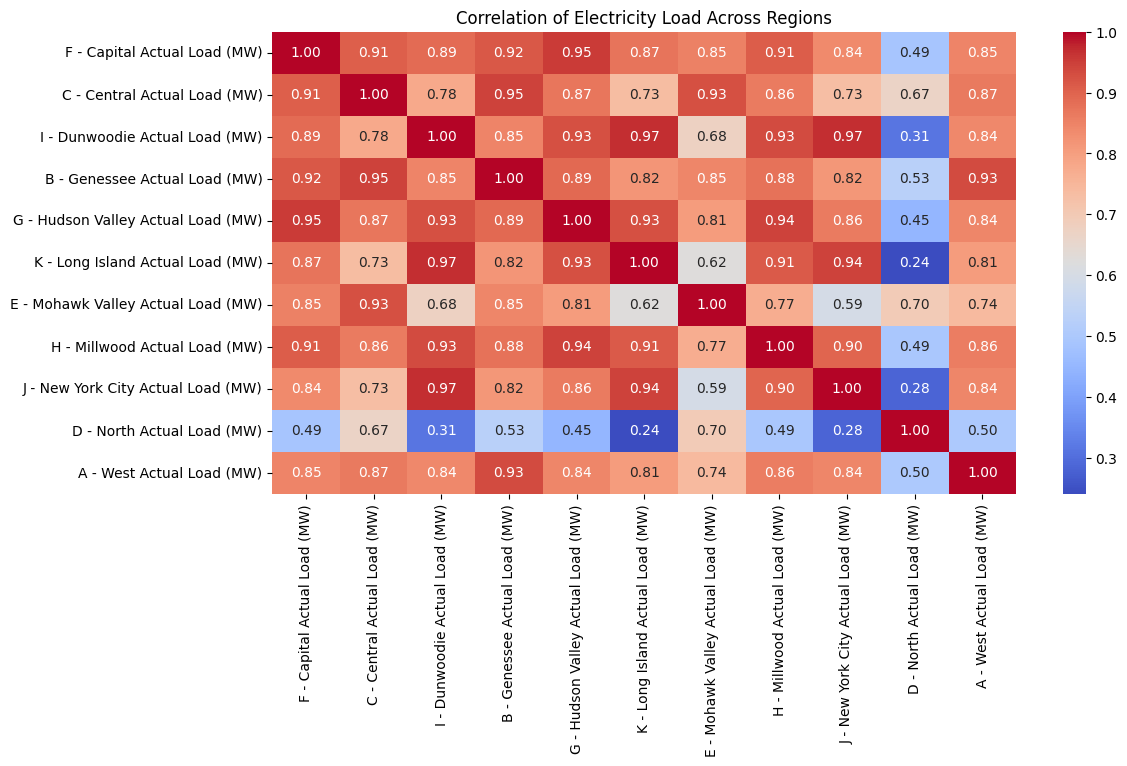

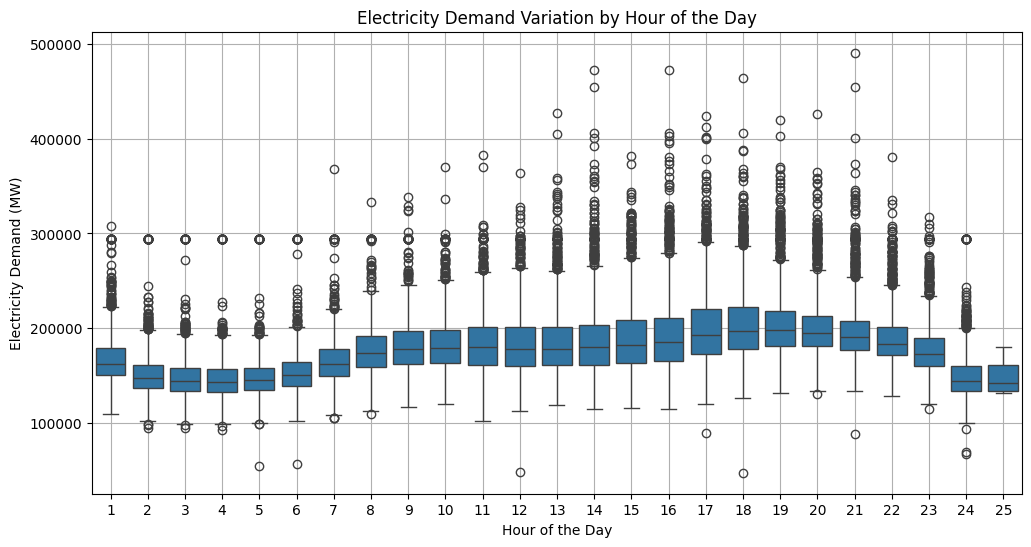

In [9]:
# Regional Load Analysis (Heatmap)

# Identify regional load columns based on column names containing "Actual Load"
regional_load_columns = [col for col in df.columns if "Actual Load" in col]

# Check if there are regional load columns available
if regional_load_columns:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df[regional_load_columns].corr(), cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Correlation of Electricity Load Across Regions")
    plt.show()
else:
    print("No regional load data found in the dataset.")

# Peak Demand Hours (Boxplot)

# Check if 'Hour Number' column exists before proceeding
if 'Hour Number' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['Hour Number'], y=df['Total Generation (MW)'])
    plt.xlabel("Hour of the Day")
    plt.ylabel("Electricity Demand (MW)")
    plt.title("Electricity Demand Variation by Hour of the Day")
    plt.grid(True)
    plt.show()
else:
    print("Hour Number column not found in the dataset.")


## Regional Load Correlation (Heatmap):

Shows the correlation between different regions' electricity load.
Strong correlations suggest regions have similar demand patterns, possibly due to shared weather conditions or economic activity.

## Peak Demand Hours (Boxplot):

Electricity demand fluctuates throughout the day.
Peak hours likely occur in the afternoon and evening when residential and commercial activity is high.
Lower demand periods are typically observed during late night/early morning hours.

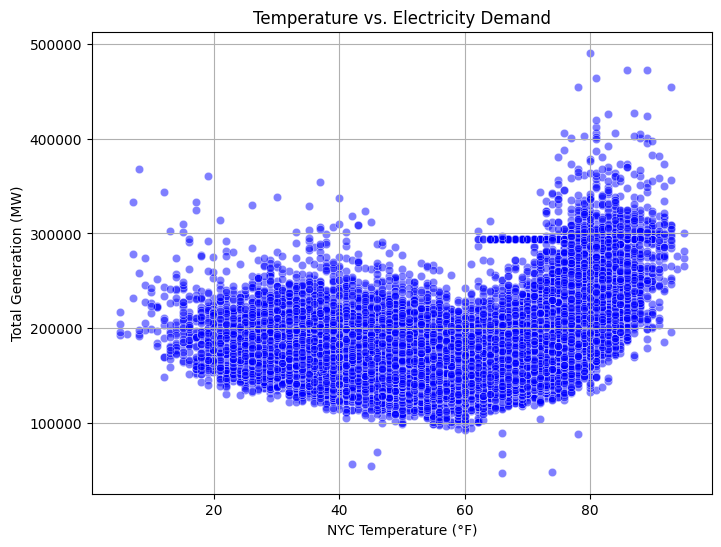

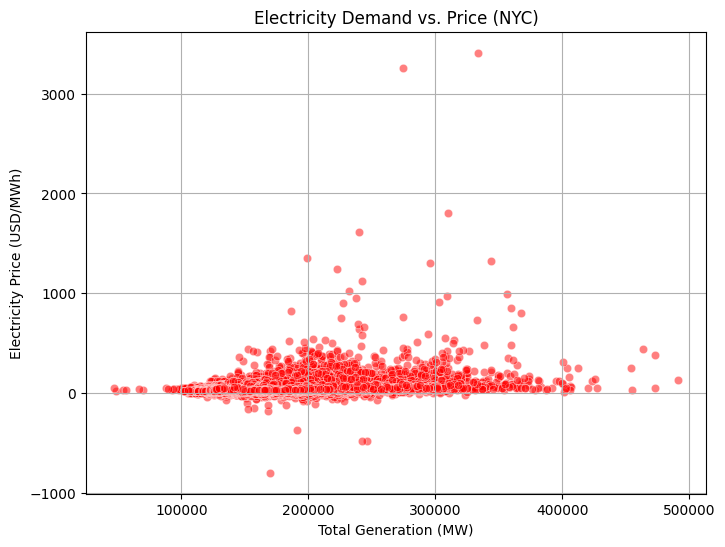

In [10]:
# Scatter plot: Temperature vs. Electricity Demand
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['New York City / JFK Airport Temperature (Fahrenheit)'],
                y=df['Total Generation (MW)'], alpha=0.5, color='blue')
plt.title("Temperature vs. Electricity Demand")
plt.xlabel("NYC Temperature (°F)")
plt.ylabel("Total Generation (MW)")
plt.grid(True)
plt.show()

# Scatter plot: Electricity Demand vs. Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Total Generation (MW)'],
                y=df['Real Time J - New York City'], alpha=0.5, color='red')
plt.title("Electricity Demand vs. Price (NYC)")
plt.xlabel("Total Generation (MW)")
plt.ylabel("Electricity Price (USD/MWh)")
plt.grid(True)
plt.show()


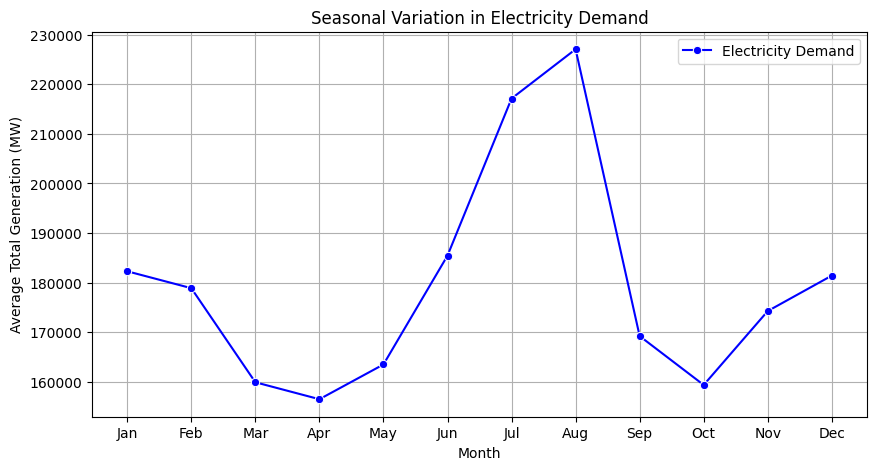

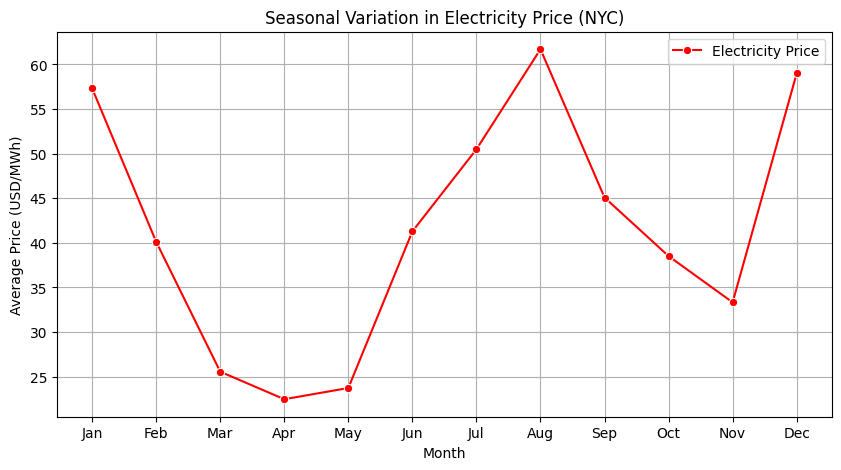

In [11]:
# Extract month from date for seasonal analysis
df['Month'] = df['Local Date'].dt.month

# Aggregate data by month
monthly_demand = df.groupby('Month')['Total Generation (MW)'].mean()
monthly_price = df.groupby('Month')['Real Time J - New York City'].mean()

# Plot seasonal electricity demand trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_demand.index, y=monthly_demand.values, marker='o', color='blue', label="Electricity Demand")
plt.title("Seasonal Variation in Electricity Demand")
plt.xlabel("Month")
plt.ylabel("Average Total Generation (MW)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()

# Plot seasonal electricity price trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_price.index, y=monthly_price.values, marker='o', color='red', label="Electricity Price")
plt.title("Seasonal Variation in Electricity Price (NYC)")
plt.xlabel("Month")
plt.ylabel("Average Price (USD/MWh)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-12-0fdeb44c336f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Month'], y=df['Real Time J - New York City'], palette="Reds")


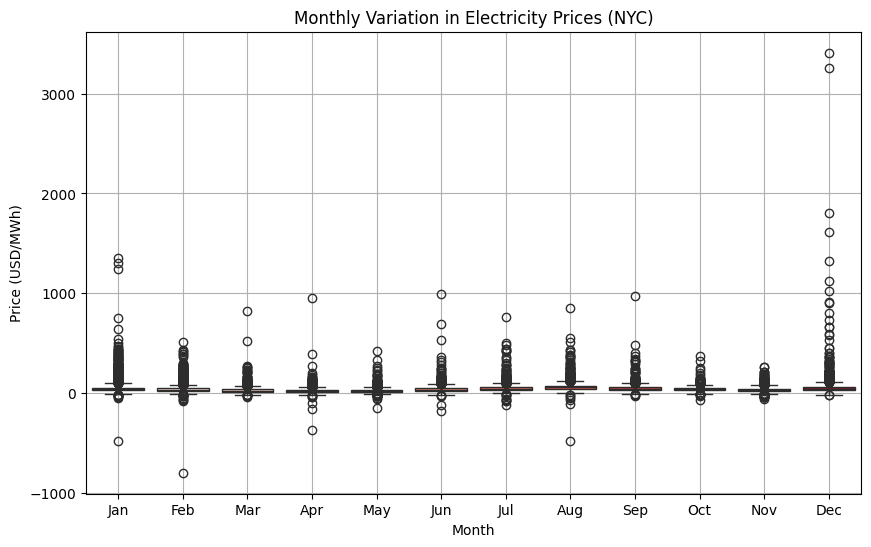

<ipython-input-12-0fdeb44c336f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Month'], y=df['Total Generation (MW)'], palette="Blues")


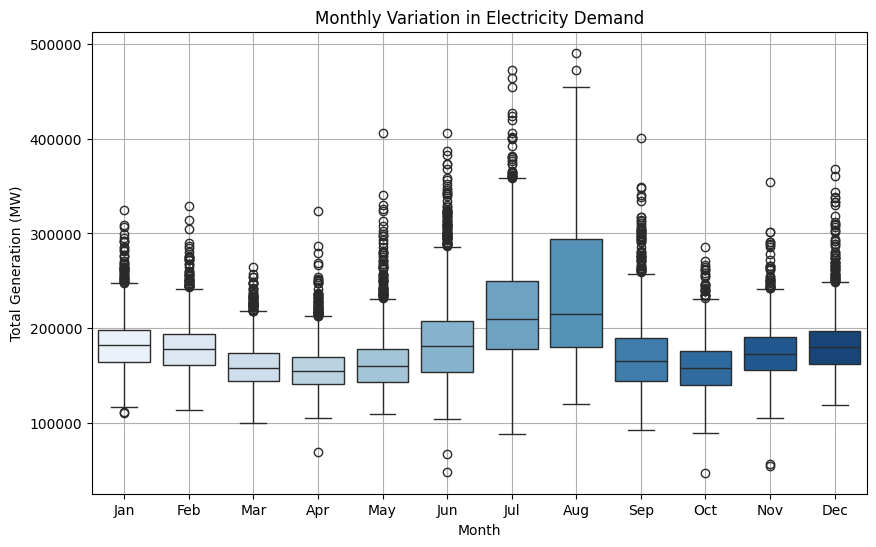

In [12]:
# 2. Boxplot of Electricity Prices by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Month'], y=df['Real Time J - New York City'], palette="Reds")
plt.title("Monthly Variation in Electricity Prices (NYC)")
plt.xlabel("Month")
plt.ylabel("Price (USD/MWh)")
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# 3. Boxplot of Electricity Demand by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Month'], y=df['Total Generation (MW)'], palette="Blues")
plt.title("Monthly Variation in Electricity Demand")
plt.xlabel("Month")
plt.ylabel("Total Generation (MW)")
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

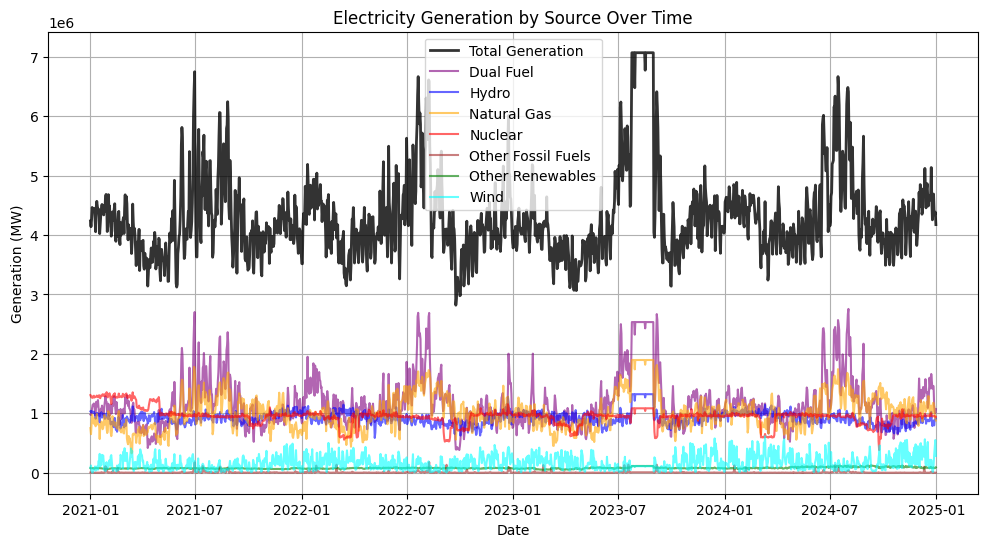

In [13]:
# Time-Series Analysis of Individual Generation Sources vs Total Generation

# Aggregating data by date for each generation type
daily_dual_fuel = df.groupby('Local Date')['Dual Fuel Generation (MW)'].sum()
daily_hydro = df.groupby('Local Date')['Hydro Generation (MW)'].sum()
daily_natural_gas = df.groupby('Local Date')['Natural Gas Generation (MW)'].sum()
daily_nuclear = df.groupby('Local Date')['Nuclear Generation (MW)'].sum()
daily_other_fossil = df.groupby('Local Date')['Other Fossil Fuels Generation (MW)'].sum()
daily_other_renewables = df.groupby('Local Date')['Other Renewables Generation (MW)'].sum()
daily_wind = df.groupby('Local Date')['Wind Generation (MW)'].sum()
daily_total = df.groupby('Local Date')['Total Generation (MW)'].sum()

# Plot all individual generation sources against total generation
plt.figure(figsize=(12, 6))
plt.plot(daily_total, label="Total Generation", color='black', linewidth=2, alpha=0.8)
plt.plot(daily_dual_fuel, label="Dual Fuel", color='purple', alpha=0.6)
plt.plot(daily_hydro, label="Hydro", color='blue', alpha=0.6)
plt.plot(daily_natural_gas, label="Natural Gas", color='orange', alpha=0.6)
plt.plot(daily_nuclear, label="Nuclear", color='red', alpha=0.6)
plt.plot(daily_other_fossil, label="Other Fossil Fuels", color='brown', alpha=0.6)
plt.plot(daily_other_renewables, label="Other Renewables", color='green', alpha=0.6)
plt.plot(daily_wind, label="Wind", color='cyan', alpha=0.6)

# Chart details
plt.title("Electricity Generation by Source Over Time")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend()
plt.grid(True)
plt.show()


## Electricity Generation by Source Over Time

Total Generation (black line) shows significant fluctuations over time, driven by seasonal demand changes.

Natural Gas (orange) and Nuclear (red) are dominant sources, contributing consistently to electricity generation.

Hydro (blue) and Wind (cyan) show more seasonal variations, likely influenced by weather conditions.

Other Renewables (green) show a slow but steady increase, reflecting the growth in sustainable energy adoption.

Dual Fuel (purple) and Other Fossil Fuels (brown) contribute sporadically, possibly used as backup sources.

## Key Insights:

Natural Gas & Nuclear remain the backbone of electricity generation.

Renewable sources (Wind, Hydro, and Other Renewables) are growing but remain a smaller fraction of total generation.

Seasonal variability impacts Hydro and Wind generation.

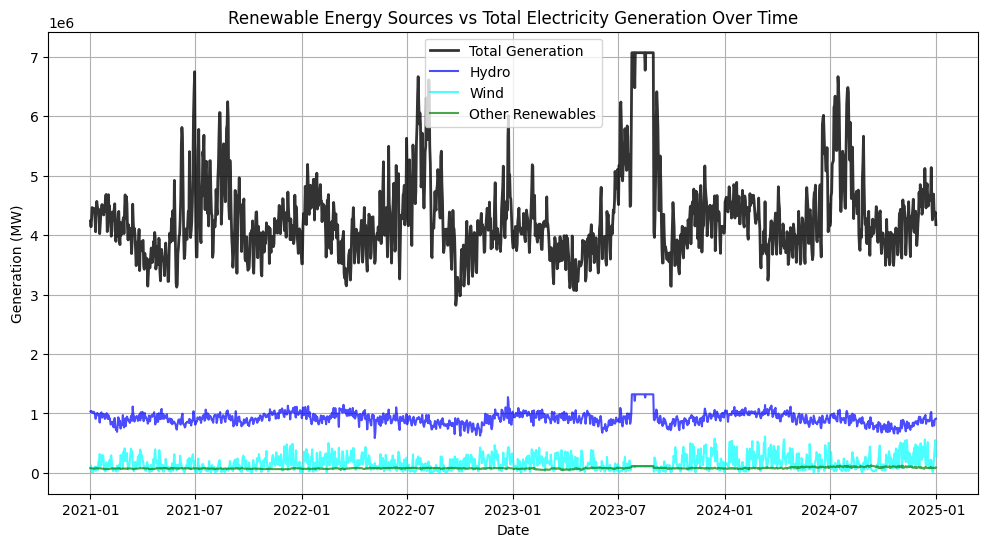

In [14]:
# Time-Series Analysis of Renewable Sources vs Total Generation

plt.figure(figsize=(12, 6))

# Plot total generation
plt.plot(daily_total, label="Total Generation", color='black', linewidth=2, alpha=0.8)

# Plot renewable energy sources
plt.plot(daily_hydro, label="Hydro", color='blue', alpha=0.7)
plt.plot(daily_wind, label="Wind", color='cyan', alpha=0.7)
plt.plot(daily_other_renewables, label="Other Renewables", color='green', alpha=0.7)

# Chart details
plt.title("Renewable Energy Sources vs Total Electricity Generation Over Time")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend()
plt.grid(True)
plt.show()


## Renewable Energy Sources vs Total Generation

Hydro (blue) is the most significant renewable source, showing periodic fluctuations likely due to seasonal water availability.

Wind (cyan) follows a more irregular pattern, indicating dependence on weather conditions.

Other Renewables (green) show a slow but steady rise, reflecting increased adoption of alternative energy sources.

Total Generation (black) remains consistently higher, emphasizing the continued reliance on non-renewable energy.

## Key Takeaways:

Hydro and Wind contribute the most among renewables but remain variable.

Other Renewables are growing steadily.

Renewable sources still make up a relatively small portion of total generation.

Most peak demand days occur in summer (June - August), aligning with high cooling needs.

Extreme price surges are seen during winter (December - January), likely due to heating demands and market volatility.

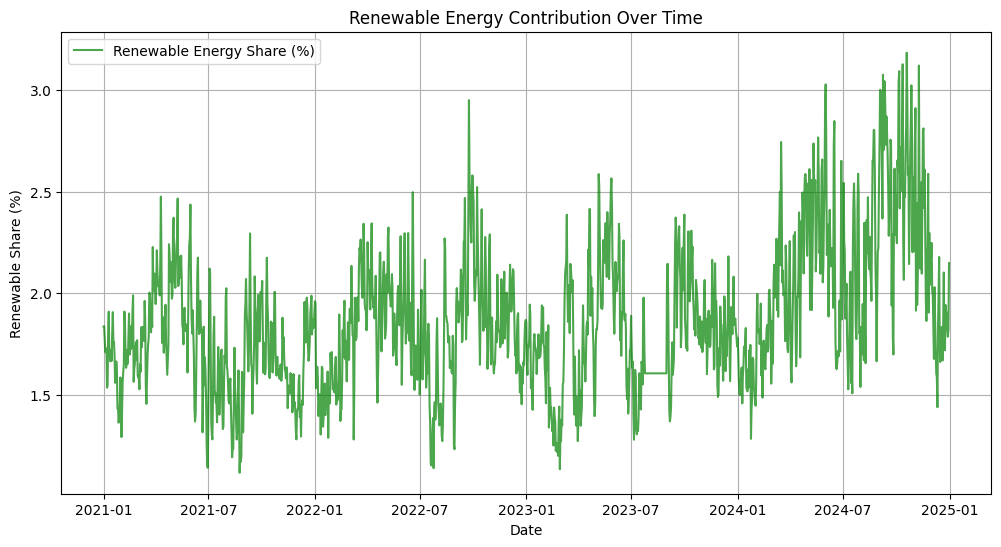

In [16]:
# Aggregate daily renewable and total generation
daily_renewable = df.groupby('Local Date')['Other Renewables Generation (MW)'].sum()
daily_total_generation = df.groupby('Local Date')['Total Generation (MW)'].sum()

# Calculate the share of renewable energy in total generation
renewable_share = (daily_renewable / daily_total_generation) * 100

# Plot renewable energy share over time
plt.figure(figsize=(12, 6))
plt.plot(renewable_share, label="Renewable Energy Share (%)", color='green', alpha=0.7)
plt.title("Renewable Energy Contribution Over Time")
plt.xlabel("Date")
plt.ylabel("Renewable Share (%)")
plt.legend()
plt.grid(True)
plt.show()


## Renewable Energy Growth Analysis:

The share of renewable energy in total electricity generation fluctuates over time.

There is a visible upward trend in renewable energy contribution, indicating increased adoption of sustainable energy sources.

Periodic dips may indicate seasonal variability in renewable energy production (e.g., lower solar or wind power during certain months).

- Peak Demand Days: Occur mainly in summer (June - August), aligning with high air conditioning usage.

- Peak Price Days: Mostly in winter (December - January), likely due to heating needs and price volatility.

- Renewable Energy Growth: Shows a general upward trend, though seasonal fluctuations exist.

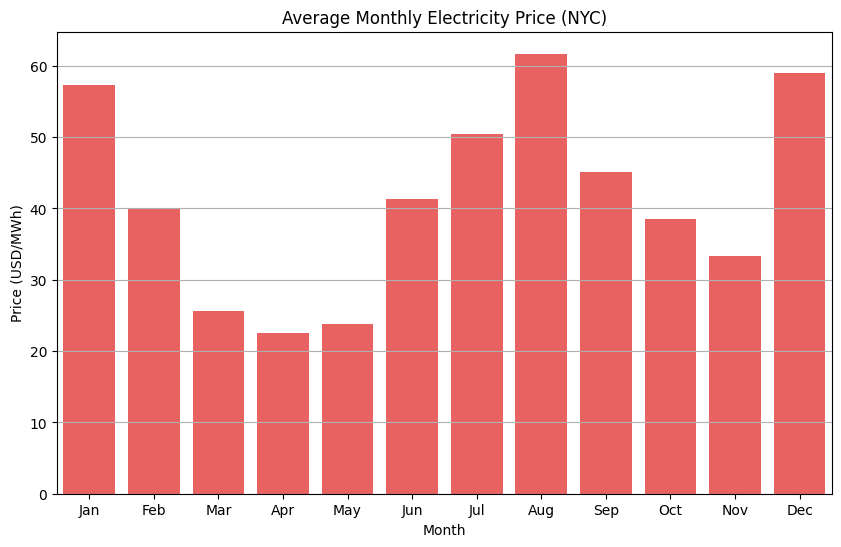

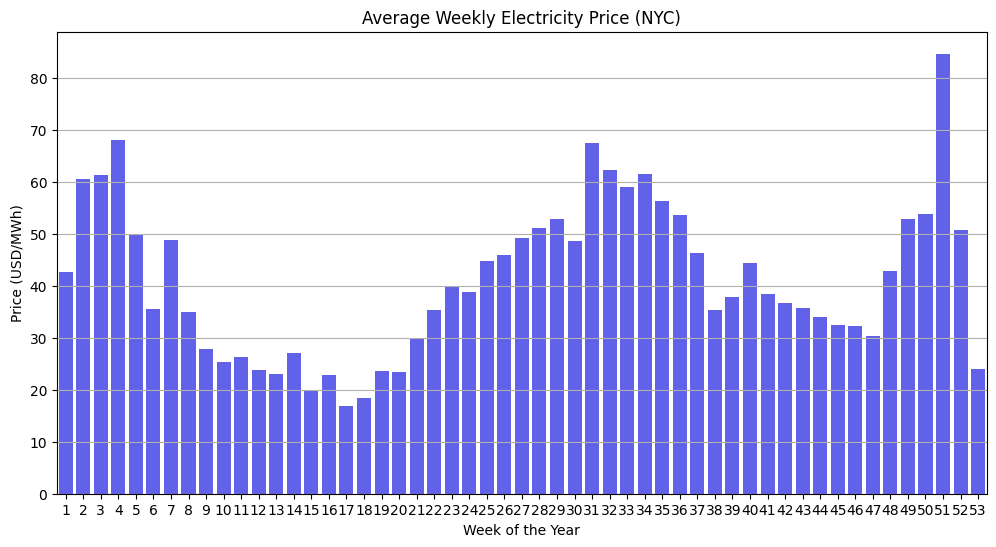

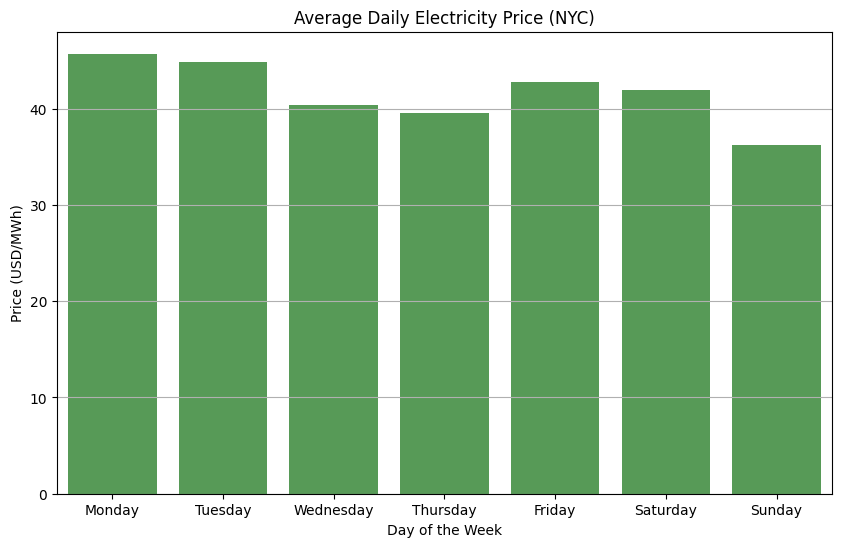

In [17]:
# Extract additional time components for grouping
df['Weekday'] = df['Local Date'].dt.day_name()
df['Week'] = df['Local Date'].dt.isocalendar().week

# Aggregate data for visualization
monthly_price_avg = df.groupby(df['Month'])['Real Time J - New York City'].mean()
weekly_price_avg = df.groupby(df['Week'])['Real Time J - New York City'].mean()
daily_price_avg = df.groupby(df['Weekday'])['Real Time J - New York City'].mean()

# Order weekdays for proper visualization
ordered_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_price_avg = daily_price_avg.reindex(ordered_weekdays)

# 1. Monthly Average Electricity Price (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_price_avg.index, y=monthly_price_avg.values, color="red", alpha=0.7)
plt.title("Average Monthly Electricity Price (NYC)")
plt.xlabel("Month")
plt.ylabel("Price (USD/MWh)")
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.show()

# 2. Weekly Average Electricity Price (Bar Plot)
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_price_avg.index, y=weekly_price_avg.values, color="blue", alpha=0.7)
plt.title("Average Weekly Electricity Price (NYC)")
plt.xlabel("Week of the Year")
plt.ylabel("Price (USD/MWh)")
plt.grid(axis='y')
plt.show()

# 3. Daily Average Electricity Price (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_price_avg.index, y=daily_price_avg.values, color="green", alpha=0.7)
plt.title("Average Daily Electricity Price (NYC)")
plt.xlabel("Day of the Week")
plt.ylabel("Price (USD/MWh)")
plt.grid(axis='y')
plt.show()


## Monthly Price Trends:

- Electricity prices tend to peak during winter (Jan, Feb) and summer (Jul - Aug) due to heating and cooling demands.
- Prices dip during spring and fall, when energy consumption is lower.

## Weekly Price Trends:

- Prices fluctuate across the weeks of the year, reflecting seasonal demand and market variations.
- Some weeks show significant spikes, possibly due to extreme weather events or policy changes.

## Daily Price Trends:

- Weekdays (Monday - Tuesday) have slightly higher electricity prices than weekends, likely due to business and commercial activities.
- Weekends (Saturday, Sunday) show slightly lower prices, indicating reduced industrial and commercial energy use.

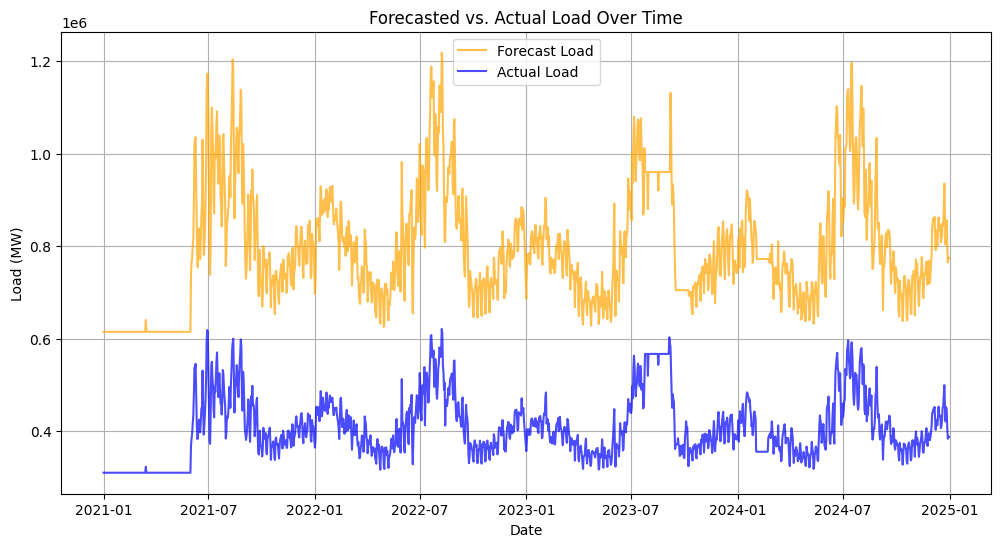

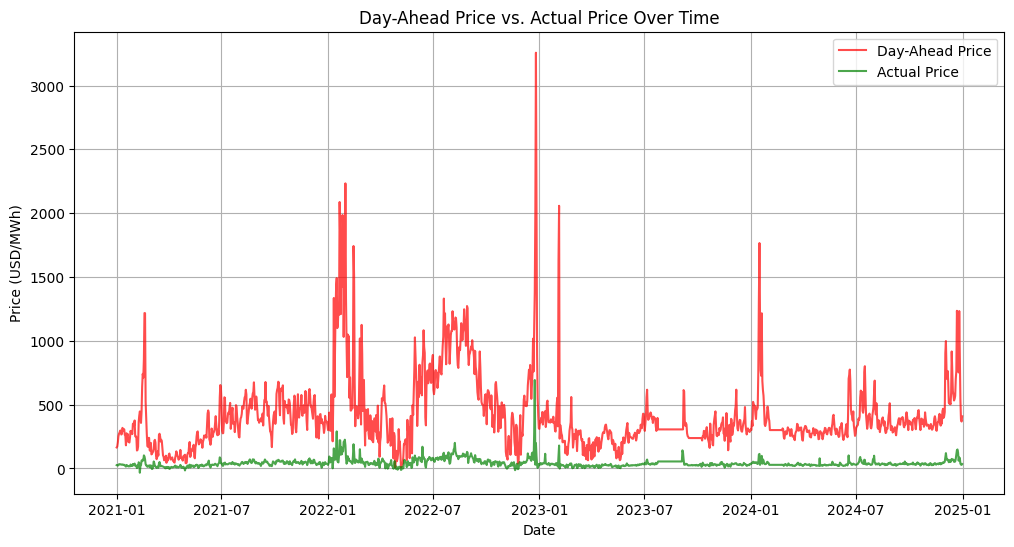

In [18]:
# Identify relevant columns for Forecast Load, Actual Load, Day-Ahead Price, and Actual Price
forecast_load_columns = [col for col in df.columns if "Forecast Load" in col]
actual_load_columns = [col for col in df.columns if "Actual Load" in col]
day_ahead_price_column = [col for col in df.columns if "DAMP" in col]  # DAMP = Day Ahead Market Price
actual_price_column = "Real Time J - New York City"  # Using NYC as representative

# Aggregate daily data for visualization
daily_forecast_load = df.groupby('Local Date')[forecast_load_columns].sum()
daily_actual_load = df.groupby('Local Date')[actual_load_columns].sum()
daily_day_ahead_price = df.groupby('Local Date')[day_ahead_price_column].mean()
daily_actual_price = df.groupby('Local Date')[actual_price_column].mean()

# Plot forecasted vs actual load
plt.figure(figsize=(12, 6))
plt.plot(daily_forecast_load.sum(axis=1), label="Forecast Load", color='orange', alpha=0.7)
plt.plot(daily_actual_load.sum(axis=1), label="Actual Load", color='blue', alpha=0.7)
plt.title("Forecasted vs. Actual Load Over Time")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

# Plot day-ahead price vs actual price
plt.figure(figsize=(12, 6))
plt.plot(daily_day_ahead_price.sum(axis=1), label="Day-Ahead Price", color='red', alpha=0.7)
plt.plot(daily_actual_price, label="Actual Price", color='green', alpha=0.7)
plt.title("Day-Ahead Price vs. Actual Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD/MWh)")
plt.legend()
plt.grid(True)
plt.show()


## Insights from Forecast Load vs Actual Load & Day-Ahead Price vs Actual Price:

### Forecasted vs. Actual Load:

- Forecast load (orange) and actual load (blue) show similar trends, but deviations exist.
- Some days have significant forecast errors, which could impact grid stability and market operations.

### Day-Ahead vs. Actual Prices:

- Day-ahead price (red) and actual price (green) generally follow the same trend.
- However, real-time prices tend to be more volatile, showing sharp fluctuations compared to the predicted day-ahead market prices.

## Key Takeaways:

- Forecasting errors in load estimation can lead to inefficiencies in energy distribution and pricing.
- Electricity prices are unpredictable, and real-time price spikes suggest the influence of external factors (e.g., demand surges, market shocks, weather events).

#### Load forecasting accuracy needs improvement to reduce deviations.

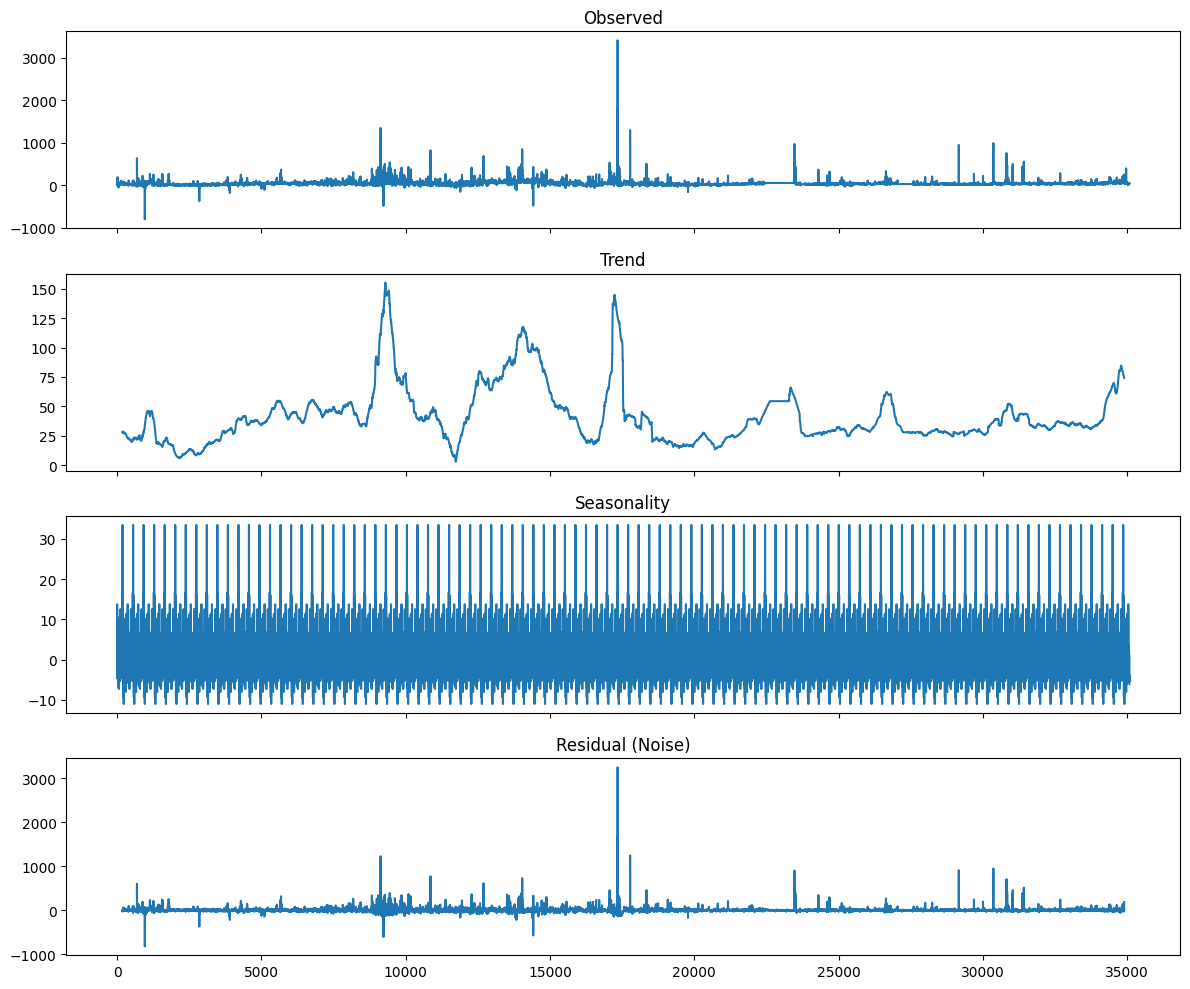

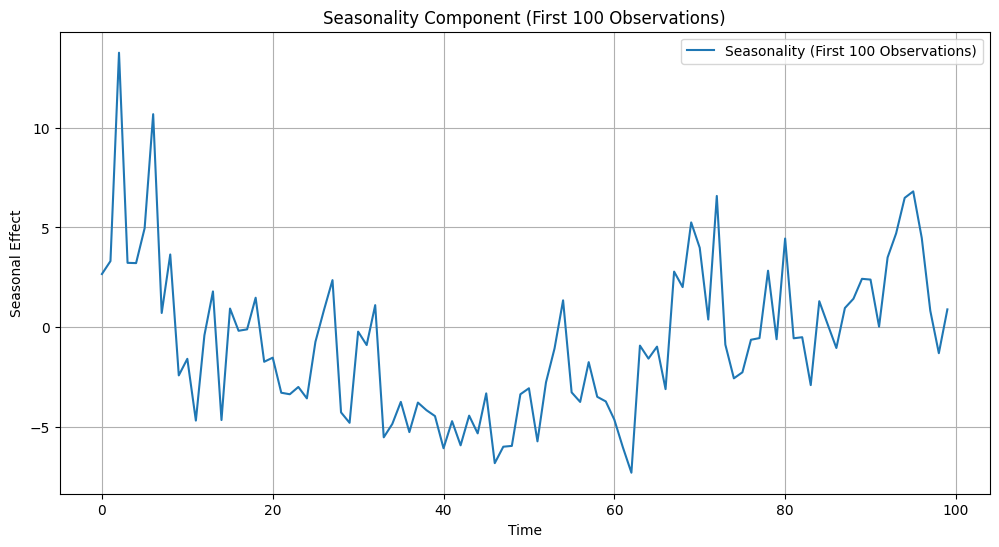

In [19]:
# Select a representative price column for analysis
price_column = 'Real Time J - New York City'

# Perform seasonal decomposition
decomposition = seasonal_decompose(df[price_column].dropna(), model='additive', period=365)

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residual (Noise)")

plt.tight_layout()
plt.show()

# Plot the first 100 observations of the seasonality component
plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal[:100], label="Seasonality (First 100 Observations)")
plt.title("Seasonality Component (First 100 Observations)")
plt.xlabel("Time")
plt.ylabel("Seasonal Effect")
plt.legend()
plt.grid(True)
plt.show()

KeyError: "None of [Index(['Electricity_Demand_MWh', 'Market_Price_USD_MWh', 'Temperature_F',\n       'Total_Generation_MW'],\n      dtype='object')] are in the [columns]"